In [12]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdChemReactions, QED
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import py3Dmol

IPythonConsole.molSize = 1000,1000
IPythonConsole.drawOptions.addAtomIndices = False
IPythonConsole.drawOptions.addStereoAnnotation = True
Draw.rdDepictor.SetPreferCoordGen(True)


In [13]:
def project_3d(molecule, width=800, height=400):
    """
    Generate a Py3Dmol viewer for 3D molecular visualization.

    Parameters:
    - molecule: RDKit molecule object
    - width (int): Width of the viewer (default: 800)
    - height (int): Height of the viewer (default: 400)

    Returns:
    - py3dmol.view: Py3Dmol viewer object
    """
    molecule = Chem.Mol(molecule)

    molecule = Chem.AddHs(molecule)

    # Generate 3D coordinates
    AllChem.EmbedMolecule(molecule, randomSeed=42)  # Use a specific seed for reproducibility

    # Convert RDKit molecule to pdb format
    mol_block = Chem.MolToPDBBlock(molecule)

    # Create Py3Dmol view
    viewer = py3Dmol.view(width=width, height=height)

    # Add the molecule to the viewer
    viewer.addModel(mol_block, format='pdb')

    # Style and zoom
    viewer.setStyle({'stick': {}})
    viewer.setBackgroundColor('white')
    viewer.zoomTo()

    display(viewer)

In [14]:
def peptide_cyclization(molecule):
    molecule = Chem.RemoveAllHs(molecule)

    # In the case of know NH2 group - find the index of NH
    try:
        amine_pattern = Chem.MolFromSmarts('[N;H2]')
        amine_index = molecule.GetSubstructMatches(amine_pattern)[0][0]

    except(IndexError):
        amine_pattern = Chem.MolFromSmarts('[N;H1]')
        amine_index = molecule.GetSubstructMatches(amine_pattern)[0][0]

    # Hydroxyl index must lie within a known carboxyl index
    hydroxyl_pattern = Chem.MolFromSmarts('[O;H1]')
    carboxyl_pattern = Chem.MolFromSmarts("[C,c;X3](=[O,S,P])-[O;H1]")
    carboxyl_indexes = []
    for match in molecule.GetSubstructMatches(carboxyl_pattern):
        for idx in match:
            carboxyl_indexes.append(idx)

    hydroxyl_index = molecule.GetSubstructMatches(hydroxyl_pattern)
    for match in hydroxyl_index:
        if match[0] in carboxyl_indexes:
            hydroxyl_index = match[0]
            break
        else:
            continue 

    # Get the atom of known index
    carboxyl_carbon_index = molecule.GetAtomWithIdx(hydroxyl_index).GetNeighbors()[0].GetIdx()

    mw = Chem.RWMol(molecule)

    mw.RemoveAtom(hydroxyl_index)

    mw.AddBond(amine_index,carboxyl_carbon_index,Chem.BondType.SINGLE)

    macrocycle = Chem.Mol(mw)
    macrocycle.UpdatePropertyCache()

    return macrocycle


In [15]:
# def generate_peptide(residues):


#     steps = []

#     if not len(residues) >=2:
#         raise(TypeError, "Please provide at least two amino acids")

#     reaction = AllChem.ReactionFromSmarts("[C:1](=[O:2])O.[NH2,NH1:3]>>[C:1](=[O:2])[N:3]")

#     chain = residues[0]
#     residues = residues[1:][::-1]


#     for residue in residues:
#         steps.append(chain)
#         reactants = (chain, residue)
#         chain = (reaction.RunReactants(reactants)[0][0])

#     steps.append(chain)

#     display(Draw.MolsToGridImage(steps,molsPerRow=2,subImgSize=(400,400), legends=[f"Chain Length: {i+1}" for i in range(len(steps))]) )

#     return chain

In [16]:
f1 = Chem.MolFromSmiles('OC([C@@H](CNC(CC1=CC=C(S(=O)(F)=O)C=C1)=O)N)=O')
bb1 = Chem.MolFromSmiles('N[C@H](CC1=CC=CC=C1)C(O)=O')
f2 = Chem.MolFromSmiles('NCCCC(O)=O')
bb2 = Chem.MolFromSmiles("N[C@@H](CC1=C(C(F)(F)F)C=CC=C1)C(O)=O")
bb3 = Chem.MolFromSmiles("OC(CN1CCNCC1)=O")
mols = (f1,bb1,f2,bb2,bb3)

names = "FIXED1 BB1 FIXED2 BB2 BB3"

# display(Draw.MolsToGridImage(mols,molsPerRow=3,subImgSize=(400,400),legends=names.split()) )


# peptide = generate_peptide(mols)
# print(f"Peptide SMILES:\n\t{Chem.MolToSmiles(peptide)}")
# display(peptide)

# macrocycle = peptide_cyclization(peptide)

# print(f"Macrocycle SMILES:\n\t{Chem.MolToSmiles(macrocycle)}")
# display(macrocycle)

# project_3d(macrocycle)

In [17]:
import pandas as pd



# headers = ["MW", "ALOGP", "HBA", "HBD", "PSA", "ROTB", "AROM", "ALERTS"]
# database = pd.DataFrame(columns=headers)

# properties = QED.properties(macrocycle)

# # Create a new row for the DataFrame
# new_row = {
#     'MW': properties[0],
#     'ALOGP': properties[1],
#     'HBA': properties[2],
#     'HBD': properties[3],
#     'PSA': properties[4],
#     'ROTB': properties[5],
#     'AROM': properties[6],
#     'ALERTS': properties[7],
#     }

# database.loc[0] = new_row

# display(database)

In [18]:

def split_macrocycle(macrocycle):

    peptide_bond_pattern = Chem.MolFromSmarts("NC=O")
    peptide_bonds = macrocycle.GetSubstructMatches(peptide_bond_pattern)

    molecule = Chem.RWMol(macrocycle)
    molecule.BeginBatchEdit()

    bonds_to_hydrolyze = []

    for peptide_bond in peptide_bonds:
        bond_indices = [None, None]

        for index in peptide_bond:
            atom = molecule.GetAtomWithIdx(index)

            if atom.GetAtomicNum() == 6:
                bond_indices[0] = index
            elif atom.GetAtomicNum() == 7:
                bond_indices[1] = index
            elif atom.GetAtomicNum() == 8:
                continue

        carbon = molecule.GetAtomWithIdx(bond_indices[0])

        if carbon.IsInRing():
            bonds_to_hydrolyze.append(bond_indices)

    for carbon_idx, nitrogen_idx in bonds_to_hydrolyze:
        molecule.RemoveBond(carbon_idx, nitrogen_idx)
        oxygen_idx = molecule.AddAtom(Chem.Atom(8))
        molecule.AddBond(carbon_idx, oxygen_idx, Chem.BondType.SINGLE)


    molecule.CommitBatchEdit()

    molecule.UpdatePropertyCache()

    display(molecule)

    residues = Chem.GetMolFrags(molecule, asMols=True)

    return residues

    

In [19]:
def generate_peptide(residues):


    steps = []

    if not len(residues) >=2:
        raise(TypeError, "Please provide at least two amino acids")

    nh2_reaction = AllChem.ReactionFromSmarts("[C:1](=[O:2])O.[NH2:3]>>[C:1](=[O:2])[N:3]")
    nh1_reaction = AllChem.ReactionFromSmarts("[C:1](=[O:2])O.[NH1:3]>>[C:1](=[O:2])[N:3]")

    chain = residues[0]
    residues = residues[1:][::-1]


    for residue in residues:
        steps.append(chain)
        reactants = (chain, residue)
        try:
            chain = (nh2_reaction.RunReactants(reactants)[0][0])
        except(IndexError):
            chain = (nh1_reaction.RunReactants(reactants)[0][0])

    steps.append(chain)

    display(Draw.MolsToGridImage(steps,molsPerRow=2,subImgSize=(400,400), legends=[f"Chain Length: {i+1}" for i in range(len(steps))]) )

    return chain

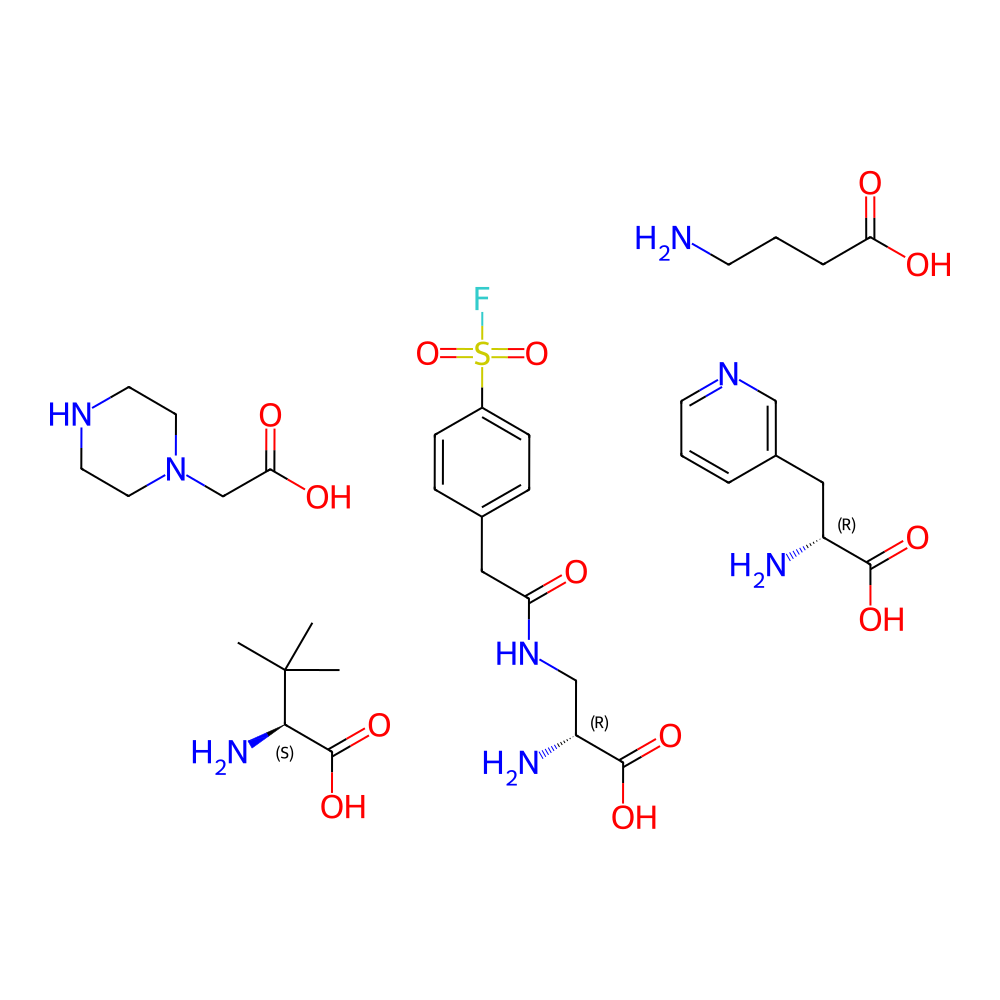

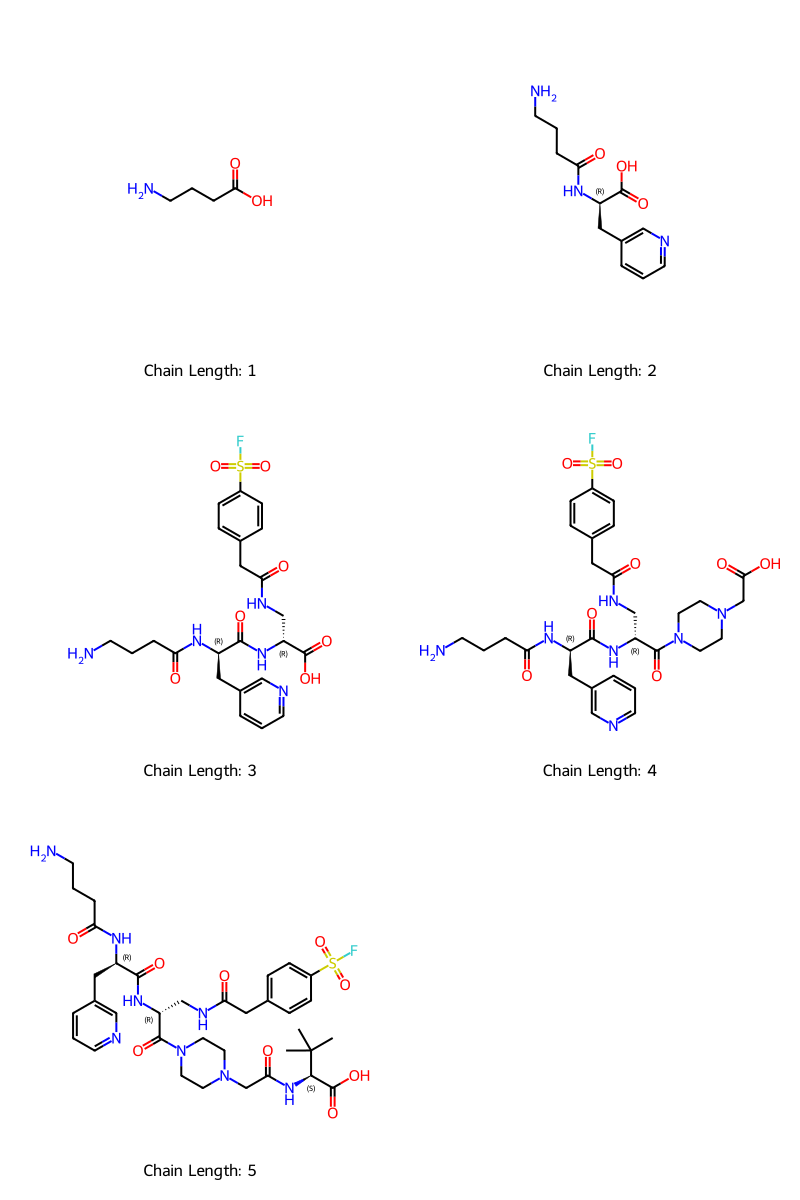

Peptide SMILES:
	CC(C)(C)[C@H](NC(=O)CN1CCN(C(=O)[C@@H](CNC(=O)Cc2ccc(S(=O)(=O)F)cc2)NC(=O)[C@@H](Cc2cccnc2)NC(=O)CCCN)CC1)C(=O)O


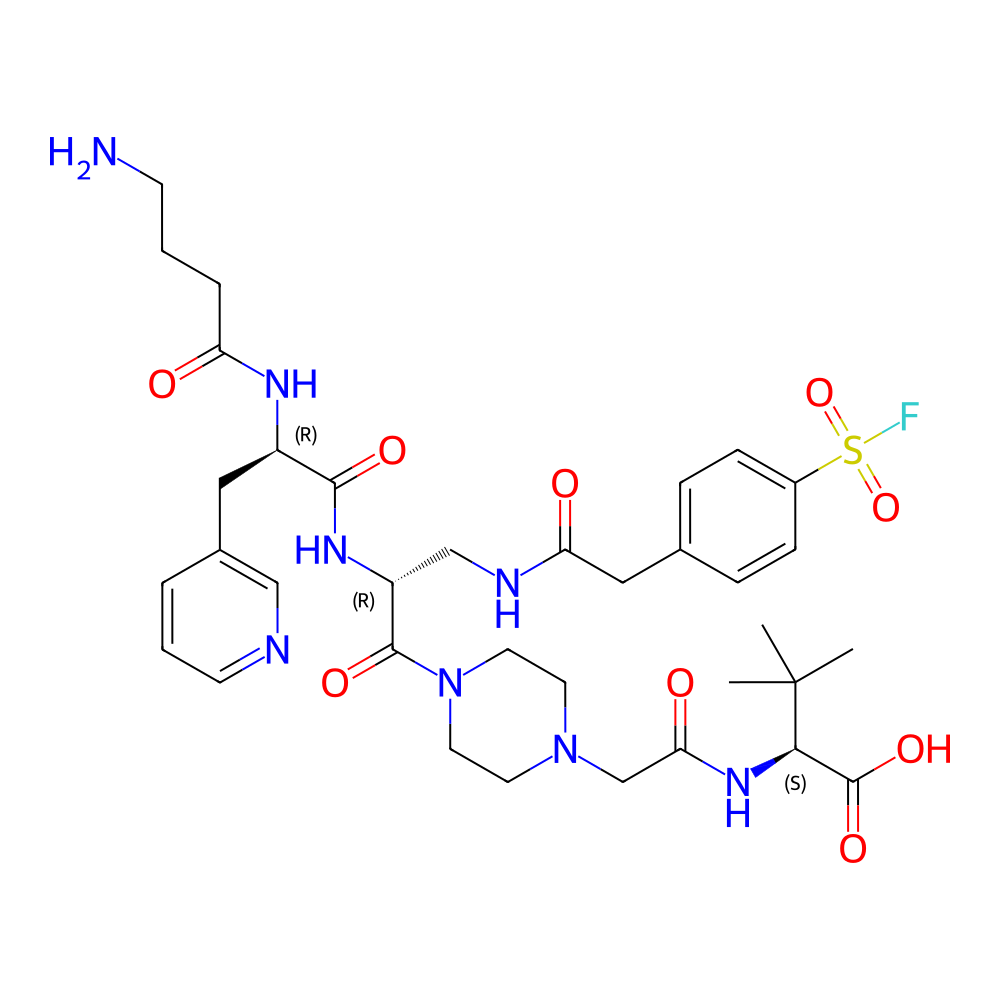

Macrocycle SMILES:
	CC(C)(C)[C@@H]1NC(=O)CN2CCN(CC2)C(=O)[C@@H](CNC(=O)Cc2ccc(S(=O)(=O)F)cc2)NC(=O)[C@@H](Cc2cccnc2)NC(=O)CCCNC1=O


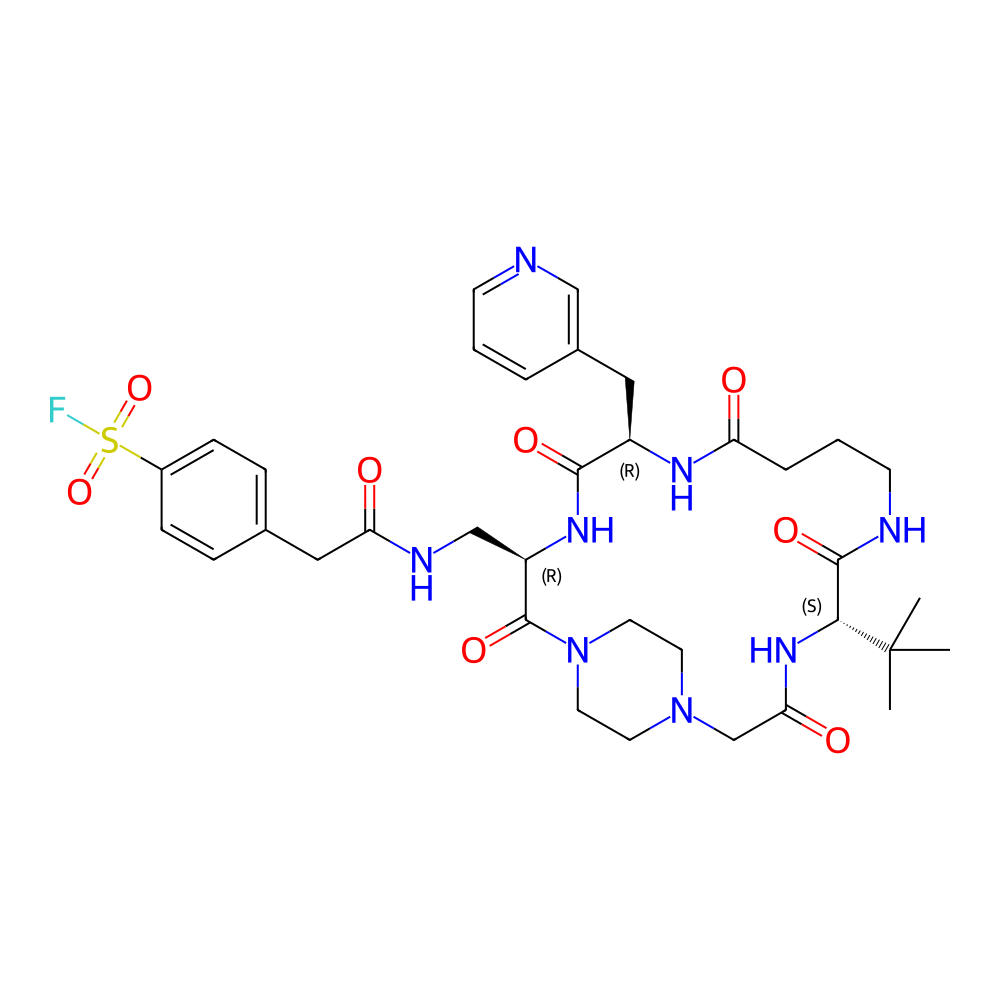

In [20]:
test_macrocycle = Chem.MolFromSmiles("O=C1CCCNC([C@@H](NC(CN2CCN(C([C@@H](CNC(CC3=CC=C(S(=O)(F)=O)C=C3)=O)NC([C@@H](CC4=CN=CC=C4)N1)=O)=O)CC2)=O)C(C)(C)C)=O")


residues = split_macrocycle(test_macrocycle)


peptide = generate_peptide(residues)
print(f"Peptide SMILES:\n\t{Chem.MolToSmiles(peptide)}")
display(peptide)

macrocycle = peptide_cyclization(peptide)

print(f"Macrocycle SMILES:\n\t{Chem.MolToSmiles(macrocycle)}")
display(macrocycle)
